In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Normalization
from tensorflow.keras.models import Model
from tensorflow.keras import utils, callbacks
from tensorflow.keras import regularizers

import sys
!pip install pyyaml h5py  # Required to save models in HDF5 format

# Set random seed for reproducibility
rs = 42
np.random.seed(rs)


# todo check if everything equals 5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
files = [
  "a280_data.csv",
  "ali535_data.csv",
  "att48_data.csv",
  # "att532_data.csv", used in testing
  "bayg29_data.csv",
  #"berlin52_data.csv", not found
  "bier127_data.csv",
  "brazil58_data.csv",
  "brg180_data.csv",
  # "burma14_data.csv", not found
  "ch130_data.csv",
  "ch150_data.csv",
  "d198_data.csv",
  # "d493_data.csv", used in testing
  "d657_data.csv",
  "d1291_data.csv",
  "d1655_data.csv",
  # "d2103_data.csv", used in testing
  "dantzig42_data.csv",
  "dsj1000_data.csv",
  "eil51_data.csv",
  "eil76_data.csv",
  "eil101_data.csv",
  "fl417_data.csv",
  #"fnl4461_data.csv", used in testing
  "fri26_data.csv",
  "gil262_data.csv",
  #"gr17_data.csv", not found
  #"gr21_data.csv", not found
  "gr24_data.csv",
  "gr48_data.csv",
  "gr96_data.csv",
  "gr120_data.csv",
  "gr137_data.csv",
  "gr202_data.csv",
  # "gr229_data.csv", used in testing
  # "gr431_data.csv", used in testing
  # "gr666_data.csv", used in testing
  # "hk48_data.csv", not found
  "kroA100_data.csv",
  "kroA150_data.csv",
  "kroA200_data.csv",
  "kroB100_data.csv",
  #"kroB150_data.csv", used in testing
  "kroB200_data.csv",
  "kroC100_data.csv",
  "kroD100_data.csv",
  "kroE100_data.csv",
  "lin105_data.csv",
  "lin318_data.csv",
  "linhp318_data.csv",
  # "nrw1379_data.csv", used in testing
  "p654_data.csv",
  "pa561_data.csv",
  "pcb442_data.csv",
  # "pcb1173_data.csv" used in testing
  # "pcb3038_data.csv", used in testing
  "pr76_data.csv",
  "pr107_data.csv",
  "pr124_data.csv",
  "pr136_data.csv",
  "pr144_data.csv",
  "pr152_data.csv",
  "pr226_data.csv",
  "pr264_data.csv",
  # "pr299_data.csv", used in testing
  "pr439_data.csv",
  # "pr1002_data.csv" used in testing
  "rat99_data.csv",
  # "rat195_data.csv", used in testing
  # "rat575_data.csv", used in testing
  "rat783_data.csv",
  "rd100_data.csv",
  "rd400_data.csv",
  # "rl1304_data.csv", used in testing
  "rl1323_data.csv",
  # "rl1889_data.csv", used in testing
  # "rl5915_data.csv", used in testing
  # "rl5934_data.csv", used in testing
  # "si175_data.csv", used in testing
  # "si535_data.csv", used in testing
  "st70_data.csv",
  "ts225_data.csv",
  "tsp225_data.csv",
  "u159_data.csv",
  "u574_data.csv",
  "u724_data.csv",
  # "u1817_data.csv", used in testing
  # "u1060_data.csv", used in testing
  # "ulysses16_data.csv", not found
  "ulysses22_data.csv",
  # "vm1084_data.csv", used in testing
  # "u2152_data.csv", used in testing
  "u2319_data.csv",
  # "vm1748_data.csv" used in testing
]

In [ ]:
def preproces(data):

  am = np.sum(np.isnan([data['Alpha']]))
  print(am)

  xs = -1*np.ones((am, 16), dtype=np.float64)
  ys = -1*np.ones((am, 8), dtype=np.float64) # could be a problem, maybe zeros instead?

  i = 0
  k = 0
  size = len(data)

  while i < size:

      start = i
      # indexing second element of i-th row of data(frame)
      # any because isnan returns list or something
      while not np.isnan(data.iloc[[i]]['Alpha']).any():
        i += 1

      # Use idxs to randomize the order in x
      # Note that the order is still [cost, alpha, cost, alpha, ...]


      idxs = list(range(8))
      random.shuffle(idxs)

      for j in range(min(8,i-start)):
        idx = idxs[j]
        xs[k,idx*2]   = data.iloc[start + j]['Cost']
        xs[k,idx*2+1] = data.iloc[start + j]['Alpha']
        ys[k,idx]     = data.iloc[start + j]['Q-Value']

      max_cost  = np.max(xs[k,[0,2,4,6,8,10,12,14]])
      max_alpha = np.max(xs[k,[1,3,5,7,9,11,13,15]])

      # check if it learns when spots are fillers with data below

      # If our input/output pair is not made up out of 5 candidates,
      # the remainig posts will have a high costs, high alpha and low q-value
      for j in [0,2,4,6,8,10,12,14]:
        if xs[k,j] == -1:
          xs[k,j] = 2*max_cost
      
      for j in [1,3,5,7,9,11,13,15]:
        if xs[k,j] == -1:
          xs[k,j] = 2*max_alpha

      for j in range(8):
        if ys[k,j] == -1:
          ys[k,j] = 0

      i += 1
      k += 1

  assert k == am
  return xs, ys

In [ ]:
path = "/content/drive/MyDrive/Unibo/comb_opt_project/q_data/"
df = pd.read_csv(path + files[0])
x, y = preproces(df)

for i in range(1, len(files)):
  df = pd.read_csv(path + files[i])
  x_new, y_new = preproces(df)
  x = np.concatenate((x, x_new))
  y = np.concatenate((y, y_new))

print(x.shape)

x_copy = x.copy()
y_copy = y.copy()

2800
5350
480
290
1270
580
1800
1300
1500
1980
6570
12910
16550
420
10000
510
760
1010
4170
260
2620
240
480
960
1200
1370
2020
1000
1500
2000
1000
2000
1000
1000
1000
1050
3180
3180
6540
5610
4420
760
1070
1240
1360
1440
1520
2260
2640
4390
990
7830
1000
4000
13230
700
2250
2250
1590
5740
7240
220
23190
(200790, 16)


In [ ]:
x = x_copy.copy()
y = y_copy.copy()

In [ ]:
# sometimes there are massive q-values in the input, these then get stored as inf values
# Here we we set them to almost float max
y = np.where(np.isinf(y) , 1.6976931348623157e+308, y)

In [ ]:
# and then divide the array by the biggest value.
# Results in a range of [0,1]

mins = x[:,[0,2,4,6,8,10,12,14]].min(axis=1)
length = mins.shape[0]
maxs = (x[:,[0,2,4,6,8,10,12,14]] -  mins.reshape(length,1)).max(axis=1)
x[:,[0,2,4,6,8,10,12,14]] = (x[:,[0,2,4,6,8,10,12,14]] - mins.reshape((length,1))) / maxs.reshape((length,1))

mins = x[:,[1,3,5,7,9,11,13,15]].min(axis=1)
maxs = (x[:,[1,3,5,7,9,11,13,15]] -  mins.reshape(length,1)).max(axis=1)
x[:,[1,3,5,7,9,11,13,15]] = (x[:,[1,3,5,7,9,11,13,15]] - mins.reshape((length,1))) / maxs.reshape((length,1))

# For the Q-values we do the same as for the cost values, but the q-value can also be negative
# So we make sure every value is >= 0 by adding the minimum value to all
# Then we repeat the above process

mins = y[:,:].min(axis=1)
y -= mins.reshape(length,1)
mins = y[:,:].min(axis=1)
maxs = (y[:,:] -  mins.reshape(length,1)).max(axis=1)

y[:,:] = (y[:,:] - mins.reshape((length,1))) / maxs.reshape((length,1))


# If all entries in x[even] are nan, we have divided by zero because all costs were equal (to zero)
for i in range(length):
  if np.isnan(x[i,[0,2,4,6,8,10,12,14]]).all():
    x[i,[0,2,4,6,8,10,12,14]] = 0

# If all entries in x[odd] are nan, we have divided by zero because all alphas were equal (to zero)
for i in range(length):
  if np.isnan(x[i,[1,3,5,7,9,11,13,15]]).all():
    x[i,[1,3,5,7,9,11,13,15]] = 0

# If all entries in y are nan, we have divided by zero because all values were equal (to infinity)
for i in range(length):
  if np.isnan(y[i,:]).all():
    y[i,:] = 1

<ipython-input-8-c81dc24fa336>:11: RuntimeWarning: invalid value encountered in true_divide
  x[:,[1,3,5,7,9,11,13,15]] = (x[:,[1,3,5,7,9,11,13,15]] - mins.reshape((length,1))) / maxs.reshape((length,1))
<ipython-input-8-c81dc24fa336>:22: RuntimeWarning: invalid value encountered in true_divide
  y[:,:] = (y[:,:] - mins.reshape((length,1))) / maxs.reshape((length,1))


In [ ]:
for i in range(x.shape[0]):
  for j in range(16):
    if np.isnan(x[i,j]) or np.isinf(x[i,j]):
      print(x[i,:])
      print(y[i,:])
      print(max(y[i,:]))
      print(i)
      assert False
  for j in range(8):
    if np.isnan(y[i,j]) or np.isinf(y[i,j]):
      print(x[i,:])
      print(y[i,:])
      print(max(y[i,:]))
      print(i)
      assert False

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, shuffle=True, random_state=rs)

In [ ]:
# xin = Input(shape=(10,))
# x = Dense(50, activation='relu')(xin)
# x = Dense(50, activation='relu')(x)
# x = Dense(50, activation='relu')(x)
# x = Dense(50, activation='relu')(x)
# out = Dense(5, activation='sigmoid')(x)
# 0.148 on test 50 epochs, 70 files

# xin = Input(shape=(10,))
# x = Dense(20, activation='relu')(xin)
# x = Dense(20, activation='relu')(x)
# x = Dense(20, activation='relu')(x)
# x = Dense(20, activation='relu')(x)
# x = Dense(20, activation='relu')(x)
# x = Dense(20, activation='relu')(x)
# x = Dense(20, activation='relu')(x)
# x = Dense(20, activation='relu')(x)
# x = Dense(20, activation='relu')(x)
# x = Dense(20, activation='relu')(x)
# out = Dense(5, activation='sigmoid')(x)
# 0.1481 train 30 epochs, 70 files

xin = Input(shape=(16,))
x = Dense(100, activation='relu', kernel_regularizer=regularizers.L2(0.000001))(xin)
x = Dense(200, activation='relu', kernel_regularizer=regularizers.L2(0.000001))(x)
x = Dense(300, activation='relu', kernel_regularizer=regularizers.L2(0.000001))(x)
x = Dense(400, activation='relu', kernel_regularizer=regularizers.L2(0.000001))(x)
x = Dense(600, activation='relu', kernel_regularizer=regularizers.L2(0.000001))(x)
x = Dense(400, activation='relu', kernel_regularizer=regularizers.L2(0.000001))(x)
x = Dense(300, activation='relu', kernel_regularizer=regularizers.L2(0.000001))(x)
x = Dense(200, activation='relu', kernel_regularizer=regularizers.L2(0.000001))(x)
x = Dense(100, activation='relu', kernel_regularizer=regularizers.L2(0.000001))(x)
out = Dense(8, activation='sigmoid')(x)
# with high alpha and cost, low q: train 0.1, test 0.2, 5 files, 100 epochs
# with low alpha, cos and q: 0.0778 train , 0.21 test , 5 files, 100 epochs
# bigger model? :) nope

model = Model(inputs=xin,outputs=out)

In [ ]:
model.summary()
model.compile(optimizer='adam',loss='mse',metrics=['mse'])

checkpoint_filepath = '/content/drive/MyDrive/Unibo/comb_opt_project/Checkpoint/'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='mse',
    save_best_only=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 100)               1700      
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 dense_2 (Dense)             (None, 300)               60300     
                                                                 
 dense_3 (Dense)             (None, 400)               120400    
                                                                 
 dense_4 (Dense)             (None, 600)               240600    
                                                                 
 dense_5 (Dense)             (None, 400)               240400

In [ ]:
history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[model_checkpoint_callback])

Epoch 1/100
4016/4016 [==============================] - 32s 6ms/step - loss: 0.1929 - mse: 0.1919 - val_loss: 0.1897 - val_mse: 0.1890
Epoch 2/100
4016/4016 [==============================] - 24s 6ms/step - loss: 0.1888 - mse: 0.1882 - val_loss: 0.1879 - val_mse: 0.1874
Epoch 3/100
4016/4016 [==============================] - 24s 6ms/step - loss: 0.1865 - mse: 0.1860 - val_loss: 0.1856 - val_mse: 0.1850
Epoch 4/100
4016/4016 [==============================] - 23s 6ms/step - loss: 0.1859 - mse: 0.1853 - val_loss: 0.1861 - val_mse: 0.1856
Epoch 5/100
4016/4016 [==============================] - 25s 6ms/step - loss: 0.1855 - mse: 0.1850 - val_loss: 0.1853 - val_mse: 0.1848
Epoch 6/100
4016/4016 [==============================] - 24s 6ms/step - loss: 0.1853 - mse: 0.1848 - val_loss: 0.1848 - val_mse: 0.1843
Epoch 7/100
4016/4016 [==============================] - 24s 6ms/step - loss: 0.1851 - mse: 0.1846 - val_loss: 0.1846 - val_mse: 0.1841
Epoch 8/100
4016/4016 [=========================

In [ ]:
# add code to load from checkpoint
model.load_weights(checkpoint_filepath)

In [ ]:
def plot_history(model_history, keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

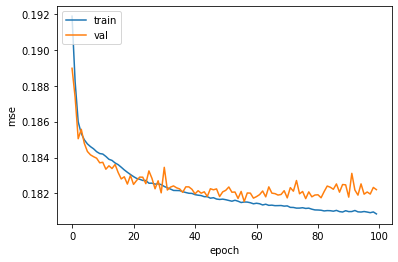

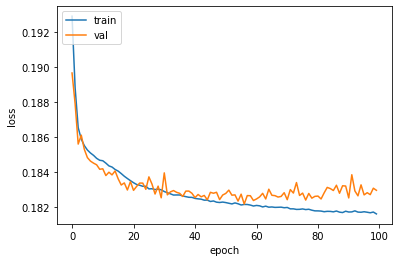

In [ ]:
plot_history(history,['mse','val_mse'])
plot_history(history,['loss','val_loss'])

In [ ]:
am = 10

pred = model.predict(x_test[:am]) # to visually check if the answers make sense
true = y_test[:am]

for i in range(am):
  print(pred[i])
  print(true[i])
  print()

1/1 [==============================] - 0s 217ms/step
[0.58616954 0.549057   0.35627127 0.36480534 0.56524175 0.3368327
 0.3455446  0.35977286]
[0.07856099 0.         0.00243977 0.00243167 1.         0.00243977
 0.00243977 0.00284227]

[0.26679513 0.2782499  0.6006223  0.2746413  0.52197546 0.27087876
 0.5698301  0.28666344]
[0.         0.         0.04134181 0.         0.0376204  0.
 1.         0.01070037]

[0.56904936 0.47071055 0.51067024 0.40435773 0.41371292 0.7154268
 0.39660385 0.3905477 ]
[0.03807507 0.03786056 1.         0.03771646 0.03829516 0.
 0.03771646 0.03771646]

[0.6980061  0.4277387  0.41293293 0.3747417  0.40803584 0.38471743
 0.7054287  0.38603243]
[0. 0. 0. 0. 0. 0. 1. 0.]

[0.46160462 0.5420153  0.34529144 0.41295403 0.34421444 0.3196958
 0.37357458 0.5679577 ]
[1.         0.         0.         0.         0.         0.
 0.34896973 0.        ]

[0.5382232  0.2967854  0.3324515  0.52755225 0.32801184 0.4471717
 0.5714154  0.30462897]
[0.         0.         0.         

In [ ]:
model.evaluate(x_test, y_test)

1255/1255 [==============================] - 3s 3ms/step - loss: 0.1831 - mse: 0.1824


[0.18314789235591888, 0.18240442872047424]